In [ ]:
! pip install mne

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

# Utilizando "1/f" para generar data realista

**Gaussiana en tiempo**

$ y = a \exp( \frac{-4\ln2(t-c)^2}{h^2})$

donde $a$ es la amplitud, $c$ es el tiempo pico y $h$ es el full-width at half maximum.

**Gaussiana en frecuencia**

$ g = \exp( \frac{-(f-c)^2}{2s^2})$

$ s = \frac{h(2 \pi - 1)}{4 \pi }$


donde $f$ en el vector de frecuencias, $c$ es la frecuencia pico y $h$ es el full-width at half maximum.

# Simulación de datos

In [ ]:
import mne
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.fft import fft, ifft
import os

# Definición de funciones para generar datos

In [ ]:
def plot_simEEG(data, times, srate, chan=0, fignum=0):
    """
    Adapted plot function for visualizing simulated EEG data.
    """
    plt.figure(fignum, figsize=(16, 10))
    plt.clf()

    # ERP
    plt.subplot(211)
    plt.plot(times, data[chan, :, :], linewidth=0.5, color=[.75, .75, .75])
    plt.plot(times, np.mean(data[chan, :, :], axis=1), 'k', linewidth=3)
    plt.xlabel('Time (s)')
    plt.ylabel('Activity')
    plt.title(f'ERP from channel {chan}')

    # Static power spectrum
    hz = np.linspace(0, srate, len(times))
    pw = np.mean((2 * np.abs(fft(data[chan, :, :], axis=1) / len(times)))**2, axis=1)
    plt.subplot(223)
    plt.plot(hz[:len(hz) // 2], pw[:len(pw) // 2], linewidth=2)
    plt.xlim([0, 50])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.title('Static power spectrum')

    # Time-frequency analysis
    frex = np.linspace(2, 30, 40)  # frequencies in Hz (2 to 30 in 40 steps)
    waves = 2 * (np.linspace(3, 10, len(frex)) / (2 * np.pi * frex))**2  # number of wavelet cycles (3 to 10)

    # setup wavelet and convolution parameters
    wavet = np.arange(-2, 2, 1/srate)
    halfw = len(wavet) // 2
    nConv = len(times) * data.shape[2] + len(wavet) - 1

    # initialize time-frequency matrix
    tf = np.zeros((len(frex), len(times)))

    # spectrum of data
    dataX = fft(data[chan, :, :].reshape(-1, order='F'), n=nConv)
    # loop over frequencies
    for fi in range(len(frex)):
        # create wavelet
        waveX = fft(np.exp(2 * 1j * np.pi * frex[fi] * wavet) * np.exp(-wavet**2 / waves[fi]), n=nConv)
        waveX = waveX / np.max(waveX) # normalize

        # convolve
        as_ = ifft(waveX * dataX)
        # trim and reshape
        as_ = as_[halfw:len(as_)-halfw+1].reshape([len(times), data.shape[2]], order='F')

        # power
        tf[fi, :] = np.mean(np.abs(as_), axis=1)

    # show a map of the time-frequency power
    plt.subplot(224)
    plt.contourf(times, frex, tf, 40, cmap='jet')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Time-frequency plot')

    plt.show()


def plot_canal(data, canal, frecuencia_muestreo, time, trial=None):
    # Extraer la señal para el canal y trial específicos
    if trial is None:
        señal = data[canal, :, :].mean(axis=1)
    else:
        señal = data[canal, :, trial]

    # Gráfico de la señal en el tiempo
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 1, 1)
    plt.plot(time, señal)
    if trial is None:
        plt.title(f'Señal promedio - Canal {canal + 1}')
    else:
        plt.title(f'Señal - Canal {canal + 1}, Trial {trial + 1}')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud')

    # Espectro de frecuencias
    frecuencias = np.linspace(0, frecuencia_muestreo / 2, len(señal) // 2)
    fft_señal = fft(señal)
    amplitud_fft = np.abs(fft_señal[:len(señal) // 2])
    plt.subplot(3, 1, 2)
    plt.plot(frecuencias, amplitud_fft)
    plt.title(f'Espectro de frecuencia - Canal {canal + 1}')
    plt.xlabel('Frecuencia (Hz)')
    plt.xlim([0, 50])
    plt.ylabel('Amplitud')

    # Análisis tiempo-frecuencia
    frex = np.linspace(1, 30, 40)  # Frecuencias en Hz (de 2 a 30 en 40 pasos)
    waves = 2 * (np.linspace(3, 10, len(frex)) / (2 * np.pi * frex))**2  # Número de ciclos de la wavelet (de 3 a 10)
    wavet = np.arange(-2, 2, 1 / frecuencia_muestreo)
    halfw = len(wavet) // 2
    nConv = len(time) * data.shape[2] + len(wavet) - 1
    tf = np.zeros((len(frex), len(time)))
    dataX = fft(señal.reshape(-1, order='F'), n=nConv)

    for fi in range(len(frex)):
        waveX = fft(np.exp(2 * 1j * np.pi * frex[fi] * wavet) * np.exp(-wavet**2 / waves[fi]), n=nConv)
        waveX = waveX / np.max(waveX)  # Normalizar
        as_ = ifft(waveX * dataX)
        as_ = as_[halfw:len(as_)-halfw+1].reshape([len(time), data.shape[2]], order='F')
        tf[fi, :] = np.mean(np.abs(as_), axis=1)

    plt.subplot(3, 1, 3)
    plt.contourf(time, frex, tf, 40, cmap='jet')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia (Hz)')
    plt.title('Gráfico tiempo-frecuencia')

    plt.tight_layout()
    plt.show()

def generar_blink(time, amplitud=100, duracion=0.1, inicio=5):
    blink = np.zeros_like(time)
    indice_inicio = np.where(time >= inicio)[0][0]
    indice_fin = np.where(time >= inicio + duracion)[0][0]
    blink[indice_inicio:indice_fin] = amplitud * np.exp(-np.arange(indice_fin - indice_inicio) / (frecuencia_muestreo * duracion))
    return blink


def generar_ruido_ac(time, frecuencia_ac=50, amplitud_ac=0.5):
    ruido_ac = amplitud_ac * np.sin(2 * np.pi * frecuencia_ac * time)
    return ruido_ac


def generar_ruido_suave(time, frecuencia_min=15, frecuencia_max=40, amplitud_max=0.05, duracion_max=2, probabilidad_ruido=0.1):
    ruido_suave = np.zeros_like(time)
    duracion_muestra = 1 / (time[1] - time[0])  # Calcula la duración de cada muestra

    i = 0
    while i < len(time):
        if np.random.rand() < probabilidad_ruido:
            # Generar un ruido suave para un segmento aleatorio
            duracion = np.random.uniform(0.5, duracion_max)
            num_muestras = int(duracion * duracion_muestra)
            frecuencia_suave = np.random.uniform(frecuencia_min, frecuencia_max)
            amplitud_suave = np.random.uniform(0.01, amplitud_max)
            ruido_segmento = amplitud_suave * np.sin(2 * np.pi * frecuencia_suave * time[i:i + num_muestras])
            ruido_suave[i:i + num_muestras] += ruido_segmento
            i += num_muestras
        else:
            i += 1

    return ruido_suave


def calcular_amplitud_ruido(posicion, n_canales, amplitud_max=1.0):
  # Calcular la distancia de la posición al centro
  distancia_al_centro = abs(posicion - n_canales / 2)
  # Normalizar la distancia y calcular la amplitud del ruido
  amplitud_ruido = amplitud_max * (1 - distancia_al_centro / (n_canales / 2))
  return amplitud_ruido


def plot_trial_superpuesto(data, trial, time, nombres_electrodos, offset=5):
    plt.figure(figsize=(15, 10))
    max_amplitud = 0
    for chani, nombre_electrodo in enumerate(nombres_electrodos):
        señal = data[chani, :, trial]
        plt.plot(time, señal + chani * offset, 'k', label=nombre_electrodo, linewidth=0.4)
        max_amplitud = max(max_amplitud, max(señal + chani * offset))

    plt.xlabel('Tiempo (s)')
    plt.title(f'Trial {trial + 1}')

    # Ajustar los límites del eje y para dejar espacio para los nombres de los canales
    plt.ylim(-offset, max_amplitud + offset)

    # Colocar los nombres de los canales a la izquierda y quitar las marcas del eje y
    plt.gca().set_yticks([])  # Quitar las marcas del eje y
    for chani, nombre_electrodo in enumerate(nombres_electrodos):
        plt.text(-0.5, chani * offset, nombre_electrodo, ha='right', va='center')

    plt.show()

def guardar_trials_como_fif(data, frecuencia_muestreo, nombres_electrodos, ruta_carpeta, prefijo_archivo='trial'):
  # Crear la información de los canales
  info = mne.create_info(ch_names=nombres_electrodos, sfreq=frecuencia_muestreo, ch_types='eeg')

  # Asegurarse de que la carpeta de destino existe
  os.makedirs(ruta_carpeta, exist_ok=True)

  for triali in range(data.shape[2]):
      # Crear un objeto Raw para el trial actual
      raw = mne.io.RawArray(data[:, :, triali], info)

      # Guardar el objeto Raw como un archivo .fif
      nombre_archivo = os.path.join(ruta_carpeta, f'{prefijo_archivo}_{triali + 1}.fif')
      raw.save(nombre_archivo, overwrite=True)

      print(f'Trial {triali + 1} guardado como {nombre_archivo}')

# Creación de datos

In [ ]:
# Crea un montaje de electrodos ficticio (reemplaza esto con tu montaje real)
montaje = mne.channels.make_standard_montage('standard_1020')
electrodos_1020 = ['Fpz', 'Fp1', 'Fp2', 'F3', 'F4', 'Fz', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                   'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Cz', 'Pz', 'A1', 'A2', 'Oz']

# Obtén las coordenadas de los electrodos
posiciones = montaje.get_positions()['ch_pos']
nombres_electrodos = list(posiciones.keys())
nombres_electrodos_filtrados = [nombre for nombre in nombres_electrodos if nombre in electrodos_1020]
coordenadas = np.array([posiciones[nombre] for nombre in nombres_electrodos_filtrados])

# Calcula la matriz de distancias euclidianas
distancias = cdist(coordenadas, coordenadas)

# Define los electrodos de interés y su importancia
electrodos_tristeza = ['C4', 'F4', 'P4']
electrodos_miedo = ['F7', 'F8']
electrodos_felicidad = ['C3', 'F3', 'P3']
electrodos_desagrado = ['Fz', 'Fpz', 'T3', 'T3']
electrodos_neutro = ['Cz']


# Peso asignado a los electrodos de interés
importancia_tristeza = 1
importancia_miedo = 0.25
importancia_felicidad = 0.5
importancia_desagrado = 1
importancia_neutro = 0.25

electrodos = [
    (electrodos_tristeza, importancia_tristeza),
    (electrodos_miedo, importancia_miedo),
    (electrodos_felicidad, importancia_felicidad),
    (electrodos_desagrado, importancia_desagrado),
    (electrodos_neutro, importancia_neutro)
    ]


# Inicializa la matriz de pesos
pesos_emociones = np.ones((len(nombres_electrodos_filtrados), len(electrodos)))  # 21 electrodos, 5 emociones

for i, (electrodos_interes, importancia) in enumerate(electrodos):
    for electrodo in electrodos_interes:
        indice = nombres_electrodos_filtrados.index(electrodo)
        # Uso de la inversa de la distancia normalizada para asignar pesos más altos a electrodos cercanos
        pesos_emociones[:, i] += (1 - distancias[indice] / np.max(distancias)) * (importancia)

# Restricción para que los pesos no sean menores que 1
pesos_emociones = np.maximum(pesos_emociones, 1.0)

# Diccionario para almacenar los pesos por emoción, con cada electrodo mapeado a su peso
pesos_por_emocion = {}

for i, emocion in enumerate(['Tristeza', 'Miedo', 'Felicidad', 'Desagrado', 'Neutro']):
    pesos_por_emocion[emocion] = {nombre_electrodo: peso for nombre_electrodo, peso in zip(nombres_electrodos_filtrados, pesos_emociones[:, i])}

pesos_min = 0.5
pesos_max = 1.5

# Normalizar los pesos para cada emoción
for emocion in pesos_por_emocion:
    pesos = np.array(list(pesos_por_emocion[emocion].values()))
    pesos_normalizados = (pesos - np.min(pesos)) / (np.max(pesos) - np.min(pesos))
    pesos_normalizados = (pesos_normalizados * (pesos_max - pesos_min) + pesos_min)
    pesos_mayor_a_2 = pesos_normalizados > 2
    pesos_normalizados[pesos_mayor_a_2] = 2
    pesos_por_emocion[emocion] = dict(zip(pesos_por_emocion[emocion].keys(), pesos_normalizados))


np.random.seed(47)
puntos_tiempo = 30  # segundos
frecuencia_muestreo = 1000  # Hz
time = np.arange(0, puntos_tiempo, 1 / frecuencia_muestreo)

n_canales = 23
n_trials = 25
data = np.zeros((n_canales, len(time), n_trials))

# Parámetros del ruido
ruido_min = 0.95  # Límite inferior del ruido
ruido_max = 1.05  # Límite superior del ruido

indice_a_electrodo = {i: nombre for i, nombre in enumerate(nombres_electrodos_filtrados)}

emocion_actual = 'Desagrado'

coordenadas_fpz = posiciones['Fpz']

distancias_a_fpz = np.linalg.norm(coordenadas - coordenadas_fpz, axis=1)

pesos_blinks = 1 - (distancias_a_fpz / np.max(distancias_a_fpz))

# Parámetros del ruido AC
frecuencia_ac = 50

amplitud_suave = np.random.uniform(0.02, 0.04)

# Parámetros del blink

for triali in range(n_trials):
    # Variaciones aleatorias para cada trial (persona)
    peaktime_var = np.random.uniform(12, 14)  # Peak time entre 12 y 14 segundos
    width_var = np.random.uniform(2.8, 3.2)  # Width entre 2.8 y 3.2.
    # El estímulo arranca mínimo en 8.8 segundos (12 - 3.2). Se define un baseline de
    freq_var = np.random.uniform(0.5, 30)  # Frecuencia principal
    freq_2_var = np.random.uniform(0.5, 30)  # Segunda frecuencia
    noise_amp_var = np.random.uniform(0.7, 4)  # Amplitud del ruido entre 0.7 y 0.9
    amplitud_blink = np.random.uniform(5, 20)
    duracion_blink = np.random.uniform(0.05, 0.1)
    inicio_blink = np.random.uniform(3, 7)

    blink = generar_blink(time, amplitud=amplitud_blink, duracion=duracion_blink, inicio=inicio_blink)
    amplitud_gauss = np.random.uniform(0.8, 1.2)
    gaus = amplitud_gauss * np.exp(-(time - peaktime_var) ** 2 / (2 * width_var ** 2))

    cosw = np.cos(2 * np.pi * freq_var * time + 2 * np.pi * np.random.uniform())
    cosw_2 = 0 #np.cos(2 * np.pi * freq_2_var * time + 2 * np.pi * np.random.uniform())

    # Generar espectro de amplitud 1/f
    ed = np.random.uniform(45, 55)
    as_ = np.squeeze(np.random.rand(1, int(len(time) / 2) - 1) * np.exp(-(np.arange(1, int(len(time) / 2))) / ed))
    as_ = np.concatenate(([as_[0]], as_, [0], as_[::-1]))
    # Coeficientes de Fourier
    fc = np.real(as_ * np.exp(1j * 2 * np.pi * np.random.rand(as_.shape[0])))
    noise = np.real(ifft(fc)) * len(time)


    for chani in range(n_canales):
        ruido_suave = generar_ruido_suave(time, probabilidad_ruido=1)

        amplitud_ruido = calcular_amplitud_ruido(chani, n_canales, amplitud_max=0.5)

        ruido_ac = generar_ruido_ac(time, frecuencia_ac=frecuencia_ac, amplitud_ac=amplitud_ruido)

        nombre_electrodo = indice_a_electrodo[chani]

        peso = pesos_por_emocion[emocion_actual][nombre_electrodo]

        # peso_ruidoso = peso * np.random.uniform(ruido_min, ruido_max)

        data[chani, :, triali] = (peso) * (cosw * gaus) + (peso) * (cosw_2 * gaus) + (noise * noise_amp_var)
        data[chani, :, triali] += (ruido_ac * np.random.randn(1))

        if nombre_electrodo.startswith('F'):
            data[chani, :, triali] += blink * pesos_blinks[chani]

        data[chani, :, triali] += ruido_suave

# Calcular el ERP promediado sobre todos los trials para un canal específico
# erp = np.mean(data[:, :, chani], axis=1)


# plot_simEEG(data, time, frecuencia_muestreo, chan=3)

# Análisis temporal y frecuencial por canal

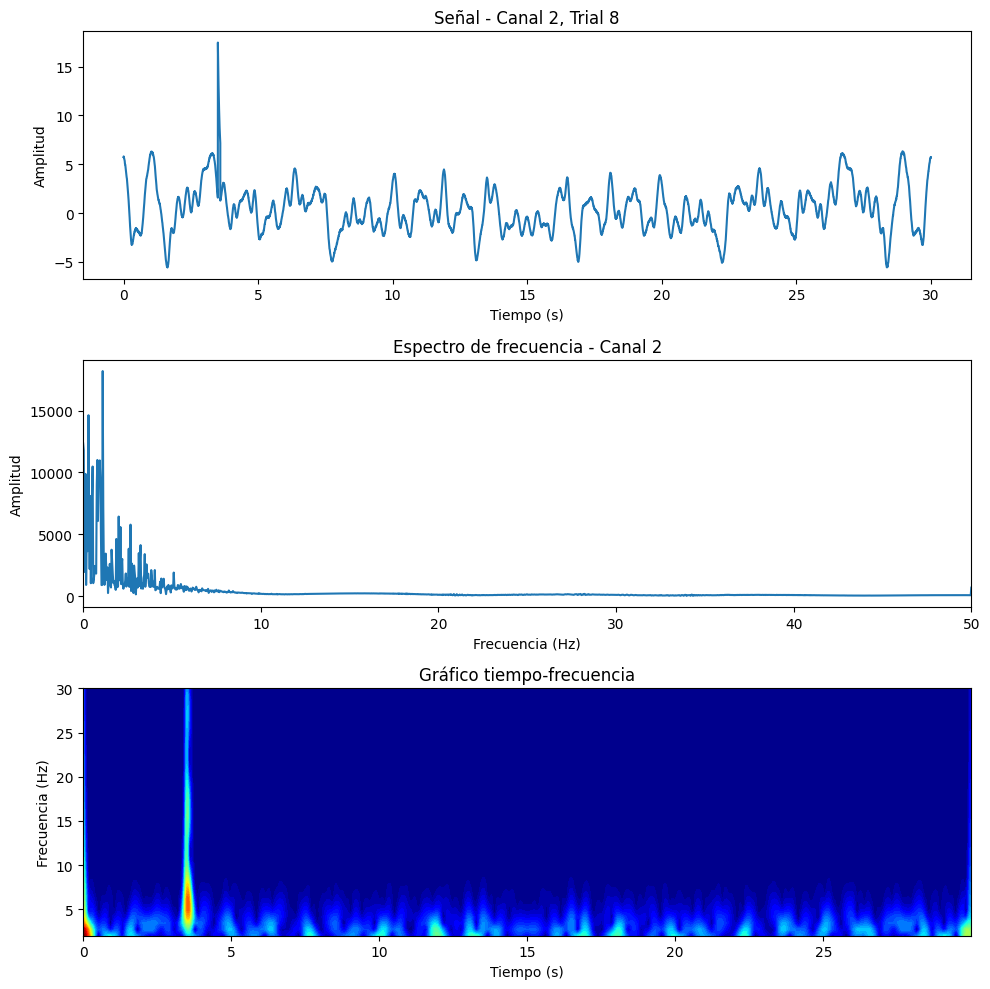

In [ ]:
plot_canal(data, 1, frecuencia_muestreo, time, trial=7)

# Dataset generado para un participante

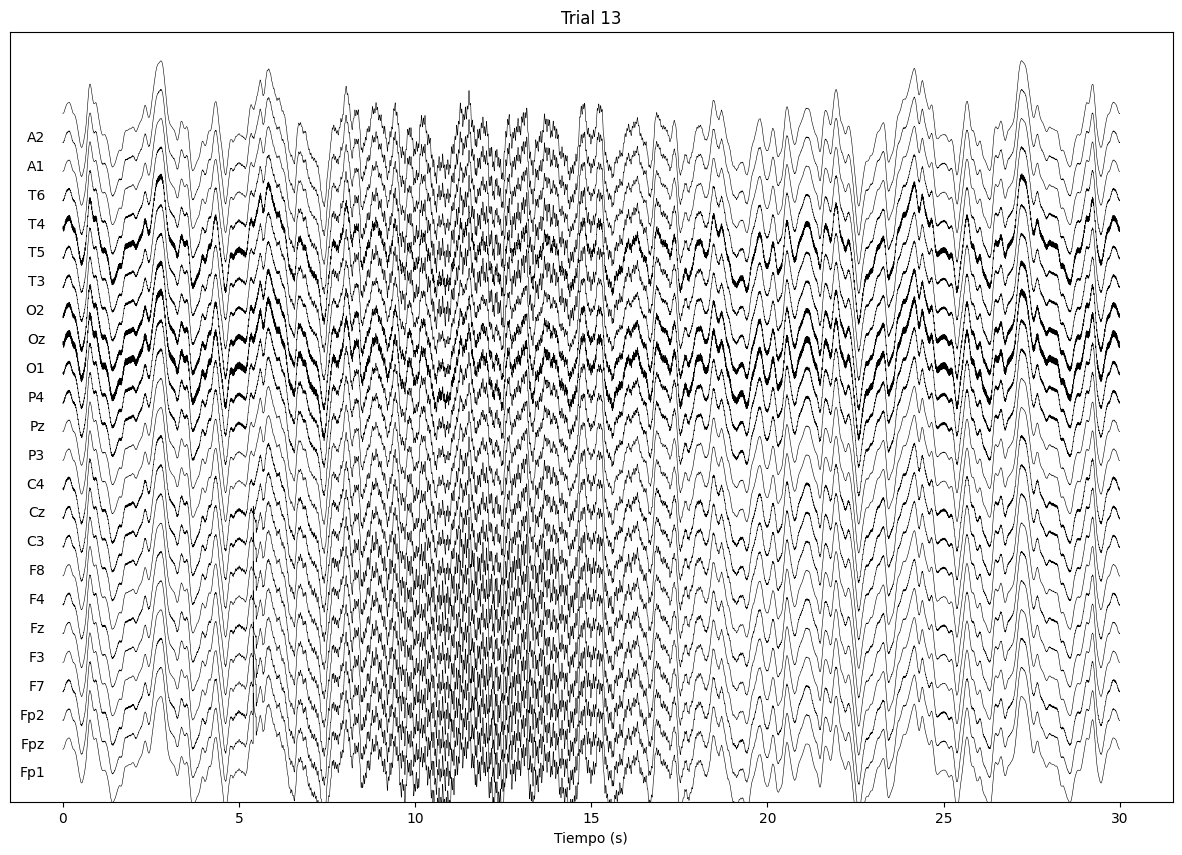

In [ ]:
plot_trial_superpuesto(data, 12, time, nombres_electrodos_filtrados)

# Guardar datos

In [ ]:
np.save('Neutral/raw_neutral.npy', data)